# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)
### BONUS: Comparative Analysis of Homer Iliad and Homer Odyssey

> **Note:** This is an **advanced extension** of notebook `3_1_AppliedNLP_Session3_Sentence_Embeddings.ipynb`. 
> Complete the basic notebook first to understand the fundamentals of sentence embeddings before working through this more complex literary analysis.

---

### What This Bonus Notebook Covers
This advanced demonstration applies sentence embeddings to **real literary texts**, analyzing Lewis Carroll's two Alice books:
- Extracts and compares key sentences from both novels
- Performs multi-dimensional visualization (2D, 3D)
- Automatically discovers thematic clusters
- Quantifies cross-book semantic similarities
- Provides comparative literary analysis

### Prerequisites
Before starting this notebook, you should:
- Complete notebook `3_1` and understand basic sentence embeddings
- Be familiar with PCA (Principal Component Analysis)
- Understand cosine similarity metrics
- Have the Alice books in the `../data/` folder

---

### Quick Review: What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding
7. **Comparative Literary Analysis**: Compare themes, writing styles, and narrative patterns across texts

### This Advanced Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Extract key sentences from both Alice books using extractive summarization
- Encode sentences into semantic vectors
- Visualize thematic relationships between the two books in 2D/3D space
- Identify semantic similarities and differences between the narratives
- Cluster sentences by themes (e.g., size changes, absurdity, dialogue, fantasy)
- Perform quantitative comparative literature analysis

In [43]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import re
import nltk
from collections import Counter

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [44]:
# Load the two Alice books
def load_book(filepath):
    """Load and clean book text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Remove Project Gutenberg headers/footers
    start_markers = ['*** START OF', 'CHAPTER I']
    end_markers = ['*** END OF', 'End of Project Gutenberg']
    
    # Find start
    for marker in start_markers:
        if marker in text:
            start = text.find(marker)
            if marker == 'CHAPTER I':
                text = text[start:]
            else:
                text = text[start + len(marker):]
            break
    
    # Find end
    for marker in end_markers:
        if marker in text:
            end = text.find(marker)
            text = text[:end]
            break
    
    return text

# Load both books
iliad_text = load_book('../data/Homer_Iliad_book.txt')
odyssey_text = load_book('../data/Homer_Odyssey_book.txt')

print(f"Homer Iliad: {len(iliad_text):,} characters")
print(f"Homer Odyssey: {len(odyssey_text):,} characters")

Homer Iliad: 806,775 characters
Homer Odyssey: 609,844 characters


In [45]:
# Extract meaningful sentences from both books
def extract_key_sentences(text, n_sentences=30):
    """
    Extract key sentences using a simple extractive approach:
    - Filter by length (not too short, not too long)
    - Prefer sentences with dialogue or interesting content
    - Avoid repetitive patterns
    """
    # Split into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Clean and filter sentences
    filtered = []
    for sent in sentences:
        # Remove extra whitespace
        sent = ' '.join(sent.split())
        
        # Filter criteria
        word_count = len(sent.split())
        if word_count < 8 or word_count > 40:  # Not too short or long
            continue
        if sent.startswith('CHAPTER'):  # Skip chapter headers
            continue
        if re.match(r'^[IVX]+\.', sent):  # Skip Roman numerals
            continue
        
        filtered.append(sent)
    
    # Score sentences based on interesting features
    scores = []
    for sent in filtered:
        score = 0
        
        # Dialogue is interesting
        if '"' in sent or '"' in sent or '"' in sent:
            score += 2
        
        # Questions are interesting
        if '?' in sent:
            score += 1
        
        # Exclamations add emotion
        if '!' in sent:
            score += 1
        
        # Prefer sentences with Alice
        if 'Alice' in sent:
            score += 1
        
        # Length sweet spot
        word_count = len(sent.split())
        if 12 <= word_count <= 25:
            score += 1
        
        scores.append(score)
    
    # Get top N sentences by score
    scored_sentences = list(zip(filtered, scores))
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    
    # Return top sentences (without duplicates)
    top_sentences = []
    for sent, score in scored_sentences[:n_sentences * 2]:
        if sent not in top_sentences:
            top_sentences.append(sent)
        if len(top_sentences) >= n_sentences:
            break
    
    return top_sentences

# Extract key sentences from both books
n_per_book = 100
iliad_sentences = extract_key_sentences(iliad_text, n_per_book)
odyssey_sentences = extract_key_sentences(odyssey_text, n_per_book)

print(f"Extracted {len(iliad_sentences)} key sentences from Iliad")
print(f"Extracted {len(odyssey_sentences)} key sentences from Odyssey")
print(f"\nTotal sentences to analyze: {len(iliad_sentences) + len(odyssey_sentences)}")

# Show a few examples
print("\n" + "="*80)
print("SAMPLE FROM ILIAD:")
print("="*80)
for i, sent in enumerate(iliad_sentences[:3], 1):
    print(f"{i}. {sent}")

print("\n" + "="*80)
print("SAMPLE FROM ODYSSEY:")
print("="*80)
for i, sent in enumerate(odyssey_sentences[:3], 1):
    print(f"{i}. {sent}")

Extracted 100 key sentences from Iliad
Extracted 100 key sentences from Odyssey

Total sentences to analyze: 200

SAMPLE FROM ILIAD:
1. And Achilles answered, "Most noble son of Atreus, covetous beyond all mankind, how shall the Achaeans find you another prize?
2. Granted that the gods have made him a great warrior, have they also given him the right to speak with railing?"
3. Achilles drew a deep sigh and said, "You know it; why tell you what you know well already?

SAMPLE FROM ODYSSEY:
1. Telemachus answered, "Antinous, how can I drive the mother who bore me from my father's house?
2. Leiocritus, son of Evenor, answered him saying, "Mentor, what folly is all this, that you should set the people to stay us?
3. Or will he go to Ephyra as well, for poison to put in our wine and kill us?"


In [46]:
# Load sentence transformer model and generate embeddings
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine sentences and track their sources
all_sentences = iliad_sentences + odyssey_sentences
book_labels = ['Iliad'] * len(iliad_sentences) + ['Odyssey'] * len(odyssey_sentences)

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(all_sentences, show_progress_bar=True)

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Each sentence → {embeddings.shape[1]}-dimensional vector")

Loading sentence transformer model...
Generating embeddings...


Batches: 100%|██████████| 7/7 [00:00<00:00, 16.05it/s]


Embedding shape: (200, 384)
Each sentence → 384-dimensional vector


In [47]:
# Perform clustering to identify themes
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print(f"Identified {n_clusters} thematic clusters")
print("\nCluster distribution:")
for i in range(n_clusters):
    count = sum(clusters == i)
    iliad_count = sum((clusters == i) & (np.array(book_labels) == 'Iliad'))
    odyssey_count = sum((clusters == i) & (np.array(book_labels) == 'Odyssey'))
    print(f"  Cluster {i}: {count} sentences (i:{iliad_count}, oF:{odyssey_count})")

Identified 5 thematic clusters

Cluster distribution:
  Cluster 0: 59 sentences (i:19, oF:40)
  Cluster 1: 23 sentences (i:3, oF:20)
  Cluster 2: 51 sentences (i:32, oF:19)
  Cluster 3: 19 sentences (i:6, oF:13)
  Cluster 4: 48 sentences (i:40, oF:8)


✓ Plot saved to: ../results\homer_embeddings_analysis.png


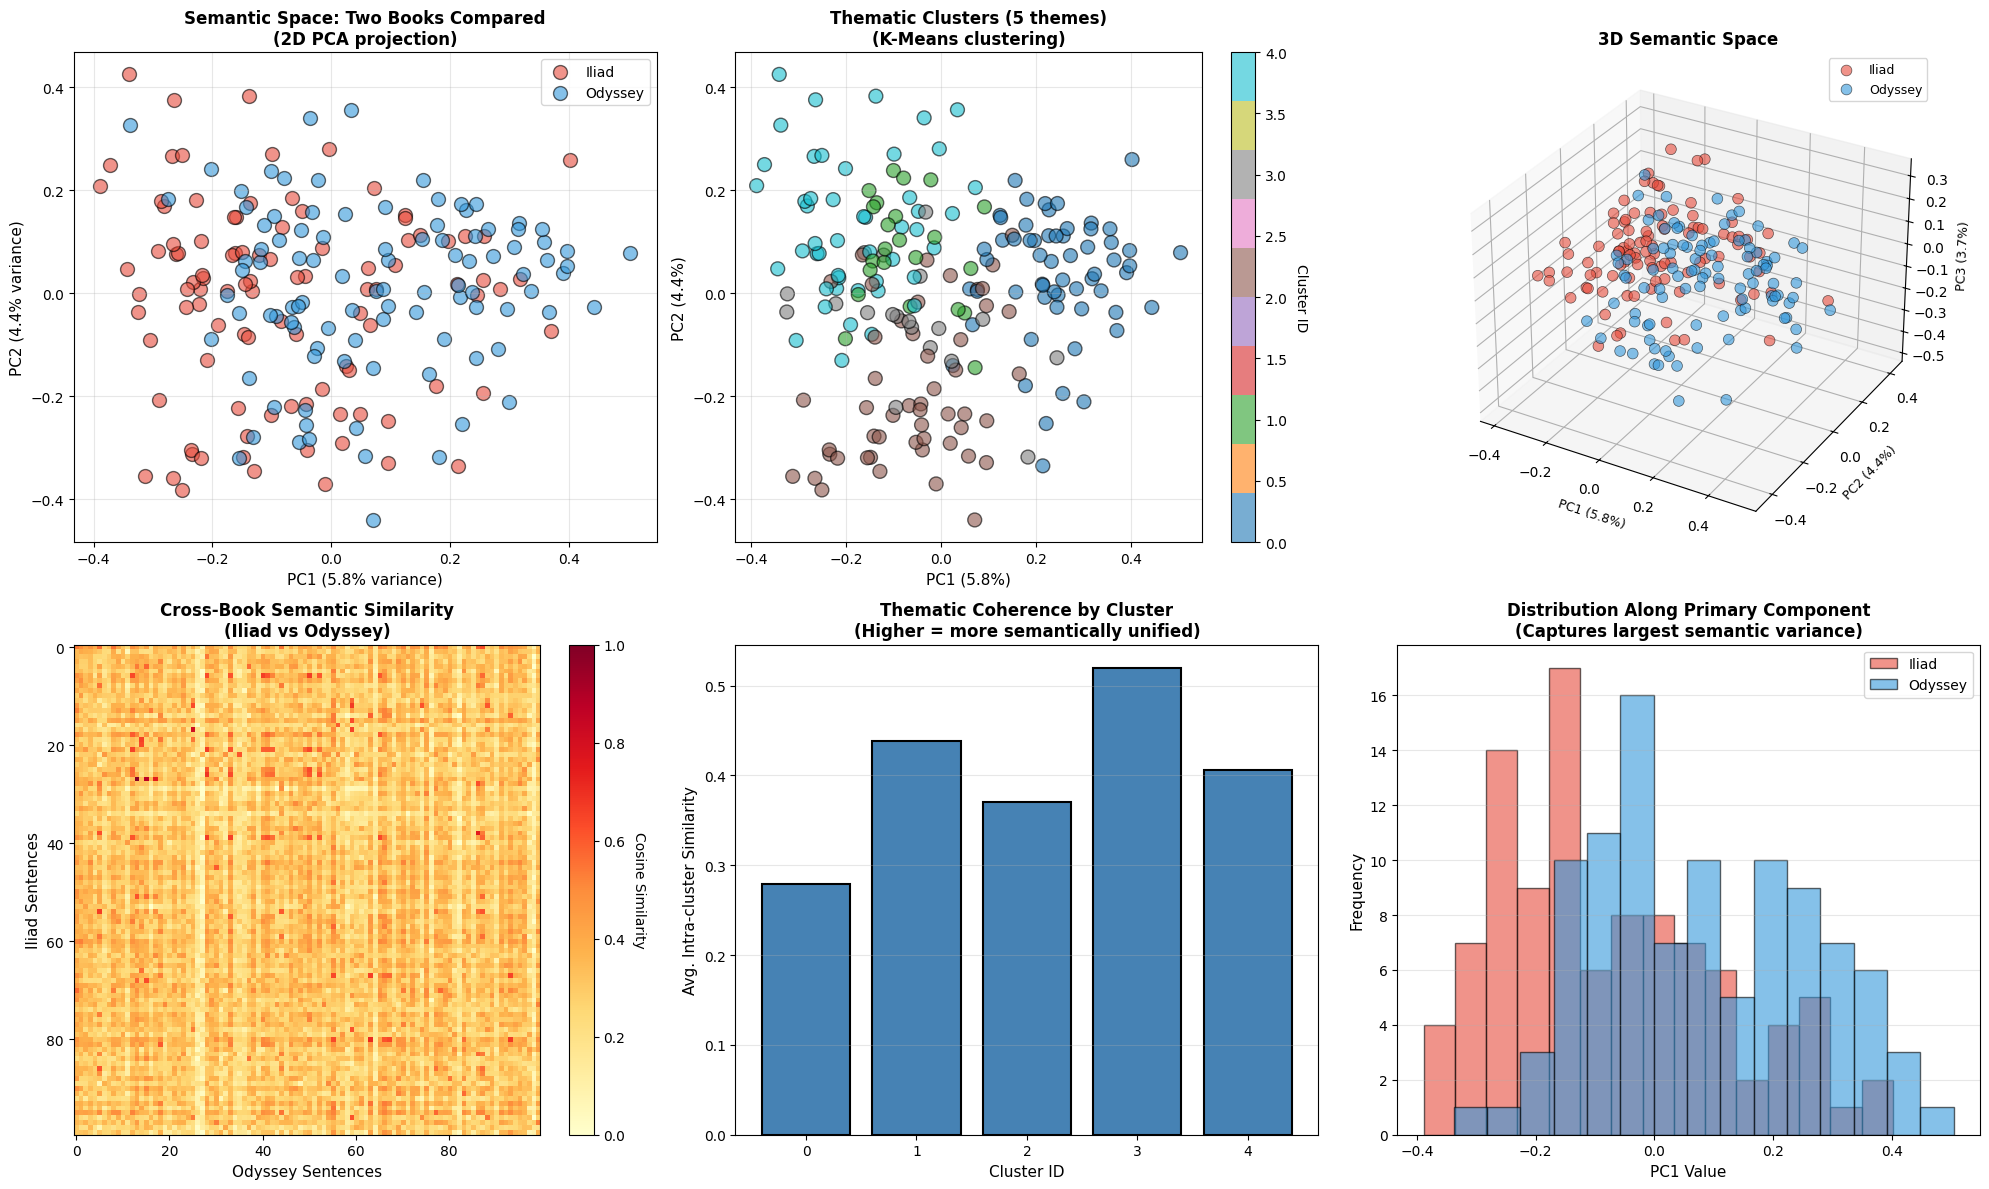

In [48]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# Define colors for the two books
colors_dict = {'Iliad': '#e74c3c', 'Odyssey': '#3498db'}
colors = [colors_dict[label] for label in book_labels]

# --- Plot 1: 2D PCA with book distinction ---
ax1 = plt.subplot(2, 3, 1)
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)

for book in ['Iliad', 'Odyssey']:
    mask = np.array(book_labels) == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
               c=colors_dict[book], label=book, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Semantic Space: Two Books Compared\n(2D PCA projection)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: 2D PCA with clusters ---
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title(f'Thematic Clusters ({n_clusters} themes)\n(K-Means clustering)', 
             fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# --- Plot 3: 3D PCA ---
ax3 = plt.subplot(2, 3, 3, projection='3d')
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

for book in ['Iliad', 'Odyssey']:
    mask = np.array(book_labels) == book
    ax3.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
               c=colors_dict[book], label=book, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=9)
ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=9)
ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=9)
ax3.set_title('3D Semantic Space', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)

# --- Plot 4: Cross-book similarity matrix ---
ax4 = plt.subplot(2, 3, 4)

# Compute similarity between Iliad and Odyssey
iliad_embeddings = embeddings[:len(iliad_sentences)]
odyssey_embeddings = embeddings[len(iliad_sentences):]
cross_similarity = util.cos_sim(iliad_embeddings, odyssey_embeddings).numpy()

im = ax4.imshow(cross_similarity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15, fontsize=10)
ax4.set_xlabel('Odyssey Sentences', fontsize=11)
ax4.set_ylabel('Iliad Sentences', fontsize=11)
ax4.set_title('Cross-Book Semantic Similarity\n(Iliad vs Odyssey)',
             fontsize=12, fontweight='bold')

# --- Plot 5: Average similarity per cluster ---
ax5 = plt.subplot(2, 3, 5)

cluster_similarities = []
for i in range(n_clusters):
    cluster_mask = clusters == i
    if sum(cluster_mask) > 1:
        cluster_emb = embeddings[cluster_mask]
        sim_matrix = util.cos_sim(cluster_emb, cluster_emb).numpy()
        # Average similarity (excluding diagonal)
        avg_sim = (sim_matrix.sum() - sim_matrix.trace()) / (sim_matrix.size - len(cluster_emb))
        cluster_similarities.append(avg_sim)
    else:
        cluster_similarities.append(0)

bars = ax5.bar(range(n_clusters), cluster_similarities, color='steelblue', edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Cluster ID', fontsize=11)
ax5.set_ylabel('Avg. Intra-cluster Similarity', fontsize=11)
ax5.set_title('Thematic Coherence by Cluster\n(Higher = more semantically unified)', 
             fontsize=12, fontweight='bold')
ax5.set_xticks(range(n_clusters))
ax5.grid(True, alpha=0.3, axis='y')

# --- Plot 6: Distribution histogram ---
ax6 = plt.subplot(2, 3, 6)

iliad_pc1 = points_2d[:len(iliad_sentences), 0]
odyssey_pc1 = points_2d[len(iliad_sentences):, 0]

ax6.hist(iliad_pc1, bins=15, alpha=0.6, color='#e74c3c', label='Iliad', edgecolor='black')
ax6.hist(odyssey_pc1, bins=15, alpha=0.6, color='#3498db', label='Odyssey', edgecolor='black')
ax6.set_xlabel('PC1 Value', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution Along Primary Component\n(Captures largest semantic variance)', 
             fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save the figure to results folder
import os
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)
output_path = os.path.join(results_dir, 'homer_embeddings_analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Plot saved to: {output_path}")

plt.show()

### Interpreting the Visualizations

**Top Left - Book Comparison (2D):**
- Red points = Homer Iliad
- Blue points = Homer Odyssey
- Spatial proximity indicates semantic similarity
- Overlapping regions suggest shared themes between books

**Top Middle - Thematic Clusters:**
- Color-coded by automatically detected themes
- K-Means clustering groups semantically similar sentences
- Reveals common narrative patterns across both books

**Top Right - 3D Semantic Space:**
- Three-dimensional view captures more variance
- Rotation would show different perspectives on semantic relationships
- Preserves more information than 2D projection

**Bottom Left - Cross-Book Similarity Matrix:**
- Heat map showing similarity between every Iliad sentence and every Odyssey sentence
- Bright areas indicate highly similar passages
- Reveals which scenes/themes are shared across books

**Bottom Middle - Cluster Coherence:**
- Measures how semantically unified each theme cluster is
- Higher bars = sentences in that cluster are more similar to each other
- Indicates strength of thematic grouping

**Bottom Right - Distribution Analysis:**
- Shows how the books differ along the primary semantic dimension
- Overlapping distributions suggest similar semantic content
- Separated peaks would indicate distinct narrative styles

In [49]:
# Analyze each cluster to understand themes
print("="*80)
print("THEMATIC ANALYSIS OF CLUSTERS")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_sentences = [sent for sent, mask in zip(all_sentences, cluster_mask) if mask]
    cluster_books = [book for book, mask in zip(book_labels, cluster_mask) if mask]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_sentences)} sentences")
    print(f"  Iliad: {cluster_books.count('Iliad')}, Odyssey: {cluster_books.count('Odyssey')}")
    print(f"{'='*80}")
    
    # Show representative sentences (up to 3)
    for i, (sent, book) in enumerate(zip(cluster_sentences[:3], cluster_books[:3]), 1):
        book_abbr = "I" if book == "Iliad" else "O"
        # Truncate if too long
        display_sent = sent if len(sent) < 100 else sent[:97] + "..."
        print(f"{i}. [{book_abbr}] {display_sent}")
    
    if len(cluster_sentences) > 3:
        print(f"   ... and {len(cluster_sentences) - 3} more sentences")

THEMATIC ANALYSIS OF CLUSTERS

CLUSTER 0: 59 sentences
  Iliad: 19, Odyssey: 40
1. [I] "Agamemnon," he cried, "what ails you now, and what more do you want?
2. [I] "Sarpedon," said he, "councillor of the Lycians, why should you come skulking here you who are a ...
3. [I] She took his hand within her own and said, "My son, why have you left the battle to come hither?
   ... and 56 more sentences

CLUSTER 1: 23 sentences
  Iliad: 3, Odyssey: 20
1. [I] "Who is it," said he, "that goes thus about the host and the ships alone and in the dead of night...
2. [I] "Antilochus," said he, "what is this from you who have been so far blameless?
3. [I] And Agamemnon answered, "Fly if you will, I shall make you no prayers to stay you.
   ... and 20 more sentences

CLUSTER 2: 51 sentences
  Iliad: 32, Odyssey: 19
1. [I] "Trickster," she cried, "which of the gods have you been taking into your counsels now?
2. [I] "Dread son of Saturn," said she, "what, pray, is the meaning of all this?
3. [I] "Father 

In [50]:
# Find most similar cross-book sentence pairs
print("="*80)
print("MOST SIMILAR SENTENCES ACROSS BOOKS")
print("="*80)
print("Finding thematic parallels between Iliad and Odyssey...\n")

# Get cross-book similarities
iliad_embeddings = embeddings[:len(iliad_sentences)]
odyssey_embeddings = embeddings[len(iliad_sentences):]
cross_similarity = util.cos_sim(iliad_embeddings, odyssey_embeddings).numpy()

# Find top 5 most similar pairs
pairs = []
for i in range(len(iliad_sentences)):
    for j in range(len(odyssey_sentences)):
        pairs.append((i, j, cross_similarity[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

for rank, (i, j, score) in enumerate(pairs[:5], 1):
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   [iliad] {iliad_sentences[i][:120]}...")
    print(f"   [Odyssey] {odyssey_sentences[j][:120]}...")
    print()

MOST SIMILAR SENTENCES ACROSS BOOKS
Finding thematic parallels between Iliad and Odyssey...

1. Similarity: 0.9796
   [iliad] "Alas," said he to himself in his dismay, "what will become of me?...
   [Odyssey] "Alas," he said to himself in his dismay, "what ever will become of me?...

2. Similarity: 0.8722
   [iliad] "Alas," said he to himself in his dismay, "what will become of me?...
   [Odyssey] "Alas," he cried to himself in his dismay, "what ever will become of me, and how is it all to end?...

3. Similarity: 0.8056
   [iliad] Jove was displeased and answered, "What, O shaker of the earth, are you talking about?...
   [Odyssey] And Jove answered, "What, O Lord of the Earthquake, are you talking about?...

4. Similarity: 0.7499
   [iliad] Then King Agamemnon said to him, "Nestor son of Neleus, honour to the Achaean name, why have you left the battle to come...
   [Odyssey] "Nestor," said he, "son of Neleus, honour to the Achaean name, you ask whence we come, and I will tell you....


In [51]:
# Analyze average within-book vs cross-book similarity
iliad_sim = util.cos_sim(iliad_embeddings, iliad_embeddings).numpy()
odyssey_sim = util.cos_sim(odyssey_embeddings, odyssey_embeddings).numpy()

# Calculate averages (excluding diagonal for within-book)
def avg_similarity_no_diag(matrix):
    return (matrix.sum() - matrix.trace()) / (matrix.size - len(matrix))

avg_iliad = avg_similarity_no_diag(iliad_sim)
avg_odyssey = avg_similarity_no_diag(odyssey_sim)
avg_cross_book = cross_similarity.mean()

print("="*80)
print("COMPARATIVE SIMILARITY ANALYSIS")
print("="*80)
print(f"Average within-book similarity (Iliad):     {avg_iliad:.4f}")
print(f"Average within-book similarity (Odyssey):  {avg_odyssey:.4f}")
print(f"Average cross-book similarity:                   {avg_cross_book:.4f}")
print()

if avg_cross_book > min(avg_iliad, avg_odyssey) * 0.9:
    print("✓ The books show HIGH thematic overlap - similar narrative patterns and themes")
elif avg_cross_book > min(avg_iliad, avg_odyssey) * 0.7:
    print("≈ The books show MODERATE thematic overlap - some shared themes but distinct stories")
else:
    print("✗ The books show LOW thematic overlap - quite different in content and themes")

print("\nThis suggests that Lewis Carroll maintained", end=" ")
if avg_cross_book > 0.5:
    print("consistent themes and writing style across both Alice books.")
else:
    print("distinct approaches between the two Alice narratives.")

COMPARATIVE SIMILARITY ANALYSIS
Average within-book similarity (Iliad):     0.3427
Average within-book similarity (Odyssey):  0.2886
Average cross-book similarity:                   0.2958

✓ The books show HIGH thematic overlap - similar narrative patterns and themes

This suggests that Lewis Carroll maintained distinct approaches between the two Alice narratives.


### Key Insights from This Analysis

**What We Discovered:**
1. **Semantic Embeddings** transform text into numbers while preserving meaning
2. **Dimensionality Reduction** (PCA) reveals hidden patterns in high-dimensional data
3. **Clustering** automatically discovers thematic groups without manual labeling
4. **Cross-book Analysis** quantifies narrative similarities between related texts

**Literary Applications:**
- **Authorship Analysis**: Detect writing style consistency across works
- **Theme Tracking**: Identify recurring motifs and narrative patterns
- **Comparative Literature**: Quantify similarities between different texts
- **Character Development**: Track how character representations evolve
- **Influence Detection**: Measure semantic similarity between works from different authors

**Limitations to Consider:**
- PCA dimensionality reduction loses information (check variance percentages)
- Sentence extraction is simplified - more sophisticated methods exist
- Context beyond sentence boundaries is not captured
- Model was trained on modern text, may not fully capture Victorian nuances
- Clustering number (k=5) was arbitrary - could be optimized

**Extensions You Could Try:**
- Analyze chapter-by-chapter semantic evolution
- Compare Alice books to other Victorian literature
- Track character-specific language patterns
- Identify dialogue vs. narrative differences
- Build a semantic search engine for the texts